# Weather Prediction with CNN (U-Net)

This notebook demonstrates how to build, train, and evaluate a convolutional neural network (U-Net) for weather prediction using reanalysis data. The workflow includes data loading, preprocessing, dataset creation for different prediction horizons, model definition, training, evaluation, and visualization of results.

---

**Sections:**
1. Import Libraries
2. Load Dataset
3. Create Prediction Datasets
4. Train/Test Split
5. DataLoader Setup
6. U-Net Model Definition
7. Training Setup
8. Training & Evaluation Loop
9. Results Visualization
10. Per-pixel RMSE Maps

Each section is documented with explanations and code.

## 1. Import Libraries

Import all necessary libraries for data handling, model building, training, and evaluation. This includes PyTorch, xarray for NetCDF data, tqdm for progress bars, and Hugging Face Hub for dataset download.

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import torch.nn.functional as F
import torch.nn as nn
from huggingface_hub import hf_hub_download

## 2. Load Dataset

Download the weather dataset from Hugging Face Hub and load it using xarray. The dataset contains air temperature data at 2 meters for multiple time steps. Display the loaded dataset for inspection.

In [2]:
file_path = hf_hub_download(repo_id="Mignar/weather-data", filename="air.2m.1981.nc", repo_type="dataset")

# Load NetCDF dataset
ds_20cr = xr.open_dataset(file_path)
ds_20cr

<xarray.Dataset> Size: 761MB
Dimensions:    (lat: 181, lon: 360, time: 2920, nbnds: 2)
Coordinates:
  * lat        (lat) float32 724B -90.0 -89.0 -88.0 -87.0 ... 88.0 89.0 90.0
  * lon        (lon) float32 1kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * time       (time) datetime64[ns] 23kB 1981-01-01 ... 1981-12-31T21:00:00
Dimensions without coordinates: nbnds
Data variables:
    air        (time, lat, lon) float32 761MB ...
    time_bnds  (time, nbnds) float64 47kB ...
Attributes: (12/24)
    Conventions:               CF-1.2
    title:                     8x Daily NOAA/CIRES/DOE 20th Century Reanalysi...
    comments:                  Data are from \nNOAA/CIRES/DOE 20th Century Re...
    standard_name_vocabulary:  NetCDF Climate and Forecast (CF) Metadata Conv...
    license:                   These data are available free of charge under ...
    spatial_resolution:        1.0 degree
    ...                        ...
    citation1:                 Slivinski, L. C, G. P. Compo, J. S. Whitaker, ...
    References:                https://www.psl.noaa.gov/data/gridded/data.20t...
    creator_name:              NOAA/PSL
    institution:               NOAA Physical Sciences Laboratory & CU/CIRES \...
    contact:                   psl.data@noaa.gov
    citation:                  Compo,G.P. <https://www.psl.noaa.gov/people/gi...

## 3. Create Prediction Datasets

Define a function to create datasets for weather prediction with configurable time horizons. The function prepares input-target pairs for different prediction steps (1, 3, and 7 steps ahead), normalizes the data, and returns PyTorch datasets. Print the number of samples for each horizon.

In [3]:
def create_prediction_dataset(ds, field_name='air', time_ahead=1):
    """
    Create a dataset for weather prediction with configurable prediction horizon.
    
    Args:
        ds: xarray Dataset containing weather data
        field_name: name of the variable to use (default: 'air')
        time_ahead: number of time steps to predict ahead (default: 1)
    """
    n_time, n_lon, n_lat = ds[field_name].shape
    
    # Create input-target pairs for timesteps
    # Input: data at time t, Target: data at time t+time_ahead
    data = torch.as_tensor(ds[field_name].values.reshape(n_time, 1, n_lon, n_lat))
    data = F.interpolate(data, size=(72, 72), mode='bilinear', align_corners=False)
    
    # Normalize the data
    data = (data - data.mean()) / data.std()
    
    # Create pairs of timesteps separated by time_ahead steps
    # inputs will be all timesteps except the last time_ahead ones
    # targets will be all timesteps from time_ahead onwards
    inputs = data[:-time_ahead]  # from t=0 to t=n-time_ahead
    targets = torch.clone(data[time_ahead:])  # from t=time_ahead to t=n
    
    # Create dataset with (input, target) pairs
    dataset = torch.utils.data.TensorDataset(inputs, targets)
    
    return dataset, n_time - time_ahead

# Create the prediction dataset with different time horizons
# Example: predict 1 time step ahead (like before)
prediction_dataset_1, n_samples_1 = create_prediction_dataset(ds_20cr, time_ahead=1)
print(f"Dataset for 1 step ahead prediction: {n_samples_1} samples")

# Example: predict 3 time steps ahead
prediction_dataset_3, n_samples_3 = create_prediction_dataset(ds_20cr, time_ahead=3)
print(f"Dataset for 3 steps ahead prediction: {n_samples_3} samples")

# Example: predict 7 time steps ahead
prediction_dataset_7, n_samples_7 = create_prediction_dataset(ds_20cr, time_ahead=7)
print(f"Dataset for 7 steps ahead prediction: {n_samples_7} samples")

Dataset for 1 step ahead prediction: 2919 samples
Dataset for 3 steps ahead prediction: 2917 samples
Dataset for 7 steps ahead prediction: 2913 samples


## 4. Train/Test Split

Split the prediction datasets into training and test sets using consecutive time steps. This ensures that the test set contains future data not seen during training. The split is performed for each prediction horizon (1, 3, and 7 steps ahead).

In [4]:
# For prediction tasks, we want consecutive test data
# Calculate the split points
n_test = int(n_samples_1 * 0.2)  # 20% for testing
n_train = n_samples_1 - n_test    # 80% for training

# Create consecutive split for the 1-step ahead prediction dataset
train_dataset_1 = torch.utils.data.Subset(prediction_dataset_1, range(0, n_train))
test_dataset_1 = torch.utils.data.Subset(prediction_dataset_1, range(n_train, n_samples_1))

# Create consecutive split for the 3-steps ahead prediction dataset
train_dataset_3 = torch.utils.data.Subset(prediction_dataset_3, range(0, n_train))
test_dataset_3 = torch.utils.data.Subset(prediction_dataset_3, range(n_train, n_samples_3))

# Create consecutive split for the 7-steps ahead prediction dataset
train_dataset_7 = torch.utils.data.Subset(prediction_dataset_7, range(0, n_train))
test_dataset_7 = torch.utils.data.Subset(prediction_dataset_7, range(n_train, n_samples_7))

print(f"Training samples: {len(train_dataset_1)}")
print(f"Test samples: {len(test_dataset_1)}")

Training samples: 2336
Test samples: 583


## 5. DataLoader Setup

Create PyTorch DataLoaders for each train and test split. DataLoaders enable efficient batching and shuffling for training, and sequential loading for testing. This step prepares the data for model training and evaluation.

In [5]:
from torch.utils.data import DataLoader

batch_size = 16

# Create DataLoaders for 1-step ahead prediction
train_dataloader_1 = DataLoader(train_dataset_1, batch_size=batch_size, shuffle=True)
test_dataloader_1 = DataLoader(test_dataset_1, batch_size=batch_size, shuffle=False)  # No shuffle for test data

# Create DataLoaders for 3-steps ahead prediction
train_dataloader_3 = DataLoader(train_dataset_3, batch_size=batch_size, shuffle=True)
test_dataloader_3 = DataLoader(test_dataset_3, batch_size=batch_size, shuffle=False)

# Create DataLoaders for 7-steps ahead prediction
train_dataloader_7 = DataLoader(train_dataset_7, batch_size=batch_size, shuffle=True)
test_dataloader_7 = DataLoader(test_dataset_7, batch_size=batch_size, shuffle=False)

print("DataLoaders created for all prediction horizons (1, 3, and 7 steps ahead)")

DataLoaders created for all prediction horizons (1, 3, and 7 steps ahead)


## 6. U-Net Model Definition

Define the U-Net architecture for weather prediction. The model consists of an encoder (contracting path) and decoder (expanding path) with skip connections. This structure enables the model to learn spatial features and reconstruct future weather maps.

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class WeatherUNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder (Contracting Path)
        self.enc1 = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        # Decoder (Expanding Path)
        self.dec3 = nn.Sequential(
            nn.Conv2d(256 + 128, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.dec2 = nn.Sequential(
            nn.Conv2d(128 + 64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.dec1 = nn.Sequential(
            nn.Conv2d(64, 32, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 1, 1)  # Final 1x1 conv to get back to 1 channel
        )
        
        # Max pooling for encoder
        self.pool = nn.MaxPool2d(2, 2)
        
        # Upsampling for decoder
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc1_pool = self.pool(enc1)
        
        enc2 = self.enc2(enc1_pool)
        enc2_pool = self.pool(enc2)
        
        enc3 = self.enc3(enc2_pool)
        
        # Decoder with skip connections
        dec3 = self.up(enc3)
        # Concatenate skip connection
        dec3 = torch.cat([dec3, enc2], dim=1)
        dec3 = self.dec3(dec3)
        
        dec2 = self.up(dec3)
        # Concatenate skip connection
        dec2 = torch.cat([dec2, enc1], dim=1)
        dec2 = self.dec2(dec2)
        
        dec1 = self.dec1(dec2)
        
        return dec1

## 7. Training Setup

Set up the training environment, including device selection (MPS, CUDA, or CPU), model instantiation for each prediction horizon, loss function (MSE), optimizers, and arrays for tracking training and test losses over epochs.

In [7]:
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Create models for different prediction horizons
model_1 = WeatherUNet().to(device)  # 1-step ahead prediction
model_3 = WeatherUNet().to(device)  # 3-steps ahead prediction
model_7 = WeatherUNet().to(device)  # 7-steps ahead prediction

# Using MSE loss for regression (predicting actual weather patterns)
loss_fn = nn.MSELoss()

# Create optimizers for each model
learning_rate = 0.001
optimizer_1 = torch.optim.Adam(model_1.parameters(), lr=learning_rate)
optimizer_3 = torch.optim.Adam(model_3.parameters(), lr=learning_rate)
optimizer_7 = torch.optim.Adam(model_7.parameters(), lr=learning_rate)

num_epochs = 25
# Initialize loss tracking arrays for each model
train_loss_1 = np.zeros(num_epochs)
test_loss_1 = np.zeros(num_epochs)
train_loss_3 = np.zeros(num_epochs)
test_loss_3 = np.zeros(num_epochs)
train_loss_7 = np.zeros(num_epochs)
test_loss_7 = np.zeros(num_epochs)

Using device: mps


## 8. Training & Evaluation Loop

Define training and testing functions. Train the models for each prediction horizon over multiple epochs, tracking loss values. Print progress and loss statistics every few epochs to monitor learning.

In [8]:
# Training function
def train_epoch(model, train_loader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Testing function
def test_epoch(model, test_loader, loss_fn, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = loss_fn(output, target)
            total_loss += loss.item()
    return total_loss / len(test_loader)

# Training loop for all models
for epoch in tqdm(range(num_epochs)):
    # Train and evaluate 1-step ahead model
    train_loss_1[epoch] = train_epoch(model_1, train_dataloader_1, optimizer_1, loss_fn, device)
    test_loss_1[epoch] = test_epoch(model_1, test_dataloader_1, loss_fn, device)
    
    # Train and evaluate 3-steps ahead model
    train_loss_3[epoch] = train_epoch(model_3, train_dataloader_3, optimizer_3, loss_fn, device)
    test_loss_3[epoch] = test_epoch(model_3, test_dataloader_3, loss_fn, device)
    
    # Train and evaluate 7-steps ahead model
    train_loss_7[epoch] = train_epoch(model_7, train_dataloader_7, optimizer_7, loss_fn, device)
    test_loss_7[epoch] = test_epoch(model_7, test_dataloader_7, loss_fn, device)
    
    # Print progress every 5 epochs
    if (epoch + 1) % 5 == 0:
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"1-step ahead - Train Loss: {train_loss_1[epoch]:.4f}, Test Loss: {test_loss_1[epoch]:.4f}")
        print(f"3-step ahead - Train Loss: {train_loss_3[epoch]:.4f}, Test Loss: {test_loss_3[epoch]:.4f}")
        print(f"7-step ahead - Train Loss: {train_loss_7[epoch]:.4f}, Test Loss: {test_loss_7[epoch]:.4f}")

 20%|██        | 5/25 [03:25<13:36, 40.82s/it]


Epoch 5/25
1-step ahead - Train Loss: 0.0029, Test Loss: 0.0032
3-step ahead - Train Loss: 0.0099, Test Loss: 0.0142
7-step ahead - Train Loss: 0.0124, Test Loss: 0.0137


 40%|████      | 10/25 [06:47<10:06, 40.43s/it]


Epoch 10/25
1-step ahead - Train Loss: 0.0018, Test Loss: 0.0023
3-step ahead - Train Loss: 0.0075, Test Loss: 0.0121
7-step ahead - Train Loss: 0.0087, Test Loss: 0.0137


 60%|██████    | 15/25 [10:10<06:45, 40.54s/it]


Epoch 15/25
1-step ahead - Train Loss: 0.0015, Test Loss: 0.0021
3-step ahead - Train Loss: 0.0059, Test Loss: 0.0097
7-step ahead - Train Loss: 0.0067, Test Loss: 0.0139


 80%|████████  | 20/25 [13:37<03:26, 41.40s/it]


Epoch 20/25
1-step ahead - Train Loss: 0.0013, Test Loss: 0.0018
3-step ahead - Train Loss: 0.0054, Test Loss: 0.0104
7-step ahead - Train Loss: 0.0056, Test Loss: 0.0140


100%|██████████| 25/25 [17:05<00:00, 41.01s/it]


Epoch 25/25
1-step ahead - Train Loss: 0.0012, Test Loss: 0.0018
3-step ahead - Train Loss: 0.0045, Test Loss: 0.0101
7-step ahead - Train Loss: 0.0047, Test Loss: 0.0147


## 9. Results Visualization

Plot training and test loss curves for all models. Compute RMSE on test sets and display sample predictions to visually assess model performance. This section helps interpret the effectiveness of the trained models.

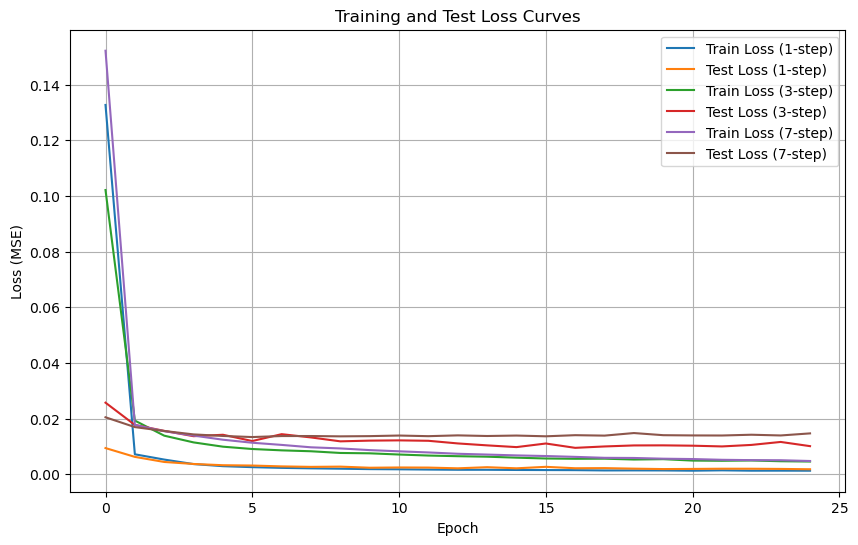

Test RMSE (1-step): 0.0421
Test RMSE (3-step): 0.1003
Test RMSE (7-step): 0.1210

Example predictions for 1-step ahead model


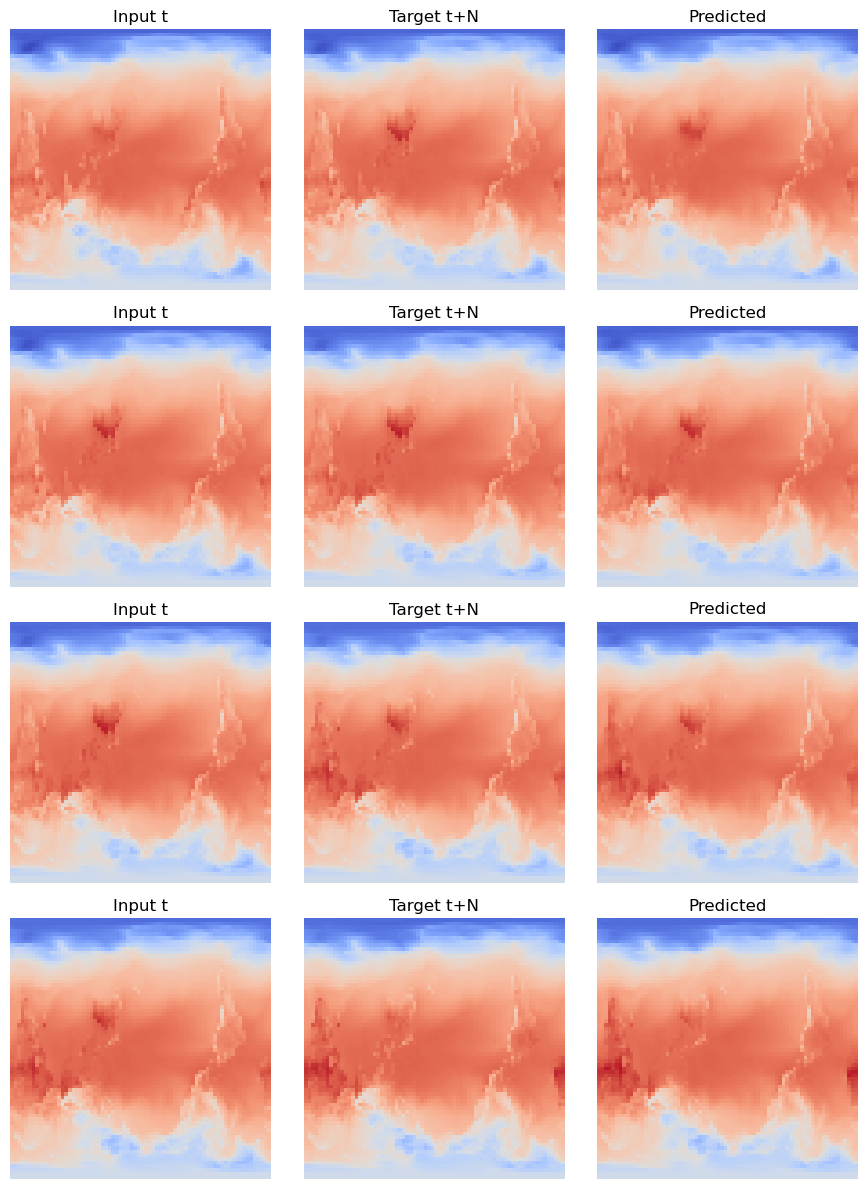


Example predictions for 3-steps ahead model


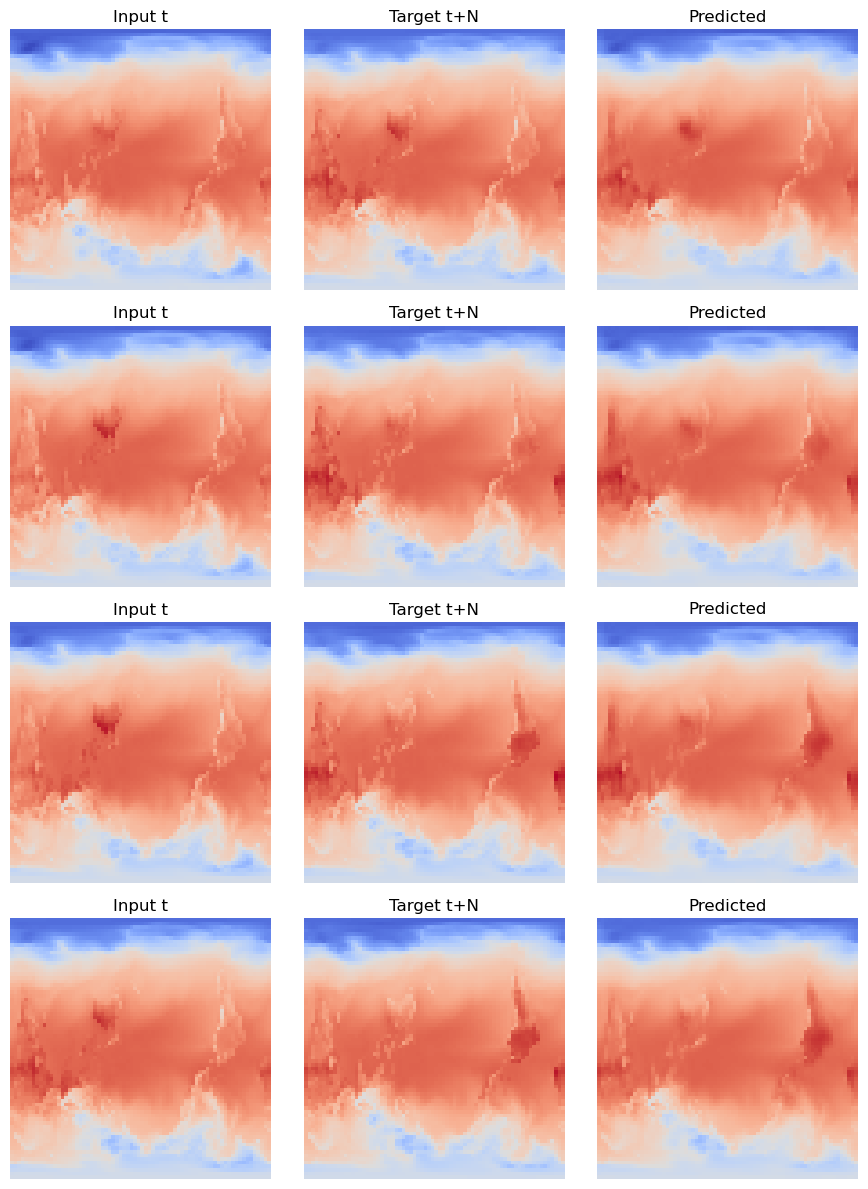


Example predictions for 7-steps ahead model


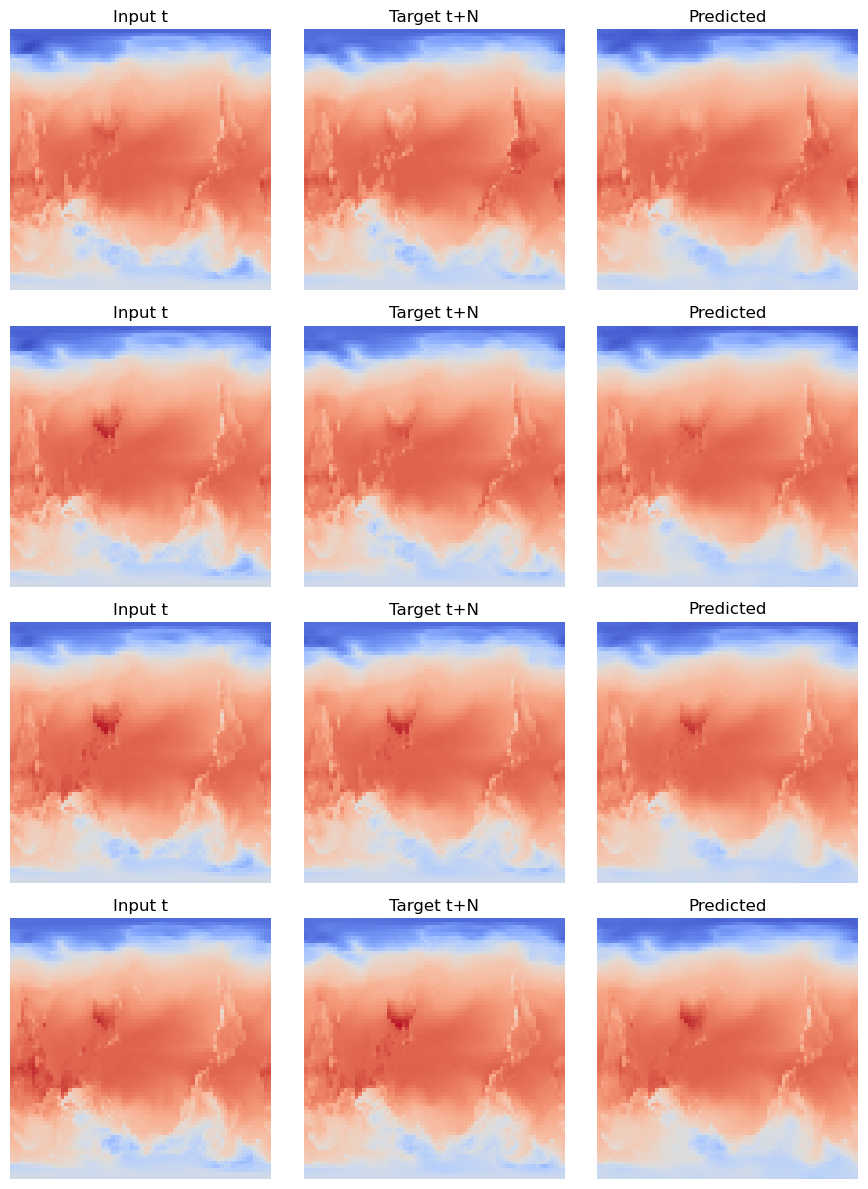

In [9]:
# Plotting losses, compute RMSE on test sets and show sample predictions
import math

def plot_loss_curves():
    plt.figure(figsize=(10,6))
    plt.plot(train_loss_1, label='Train Loss (1-step)')
    plt.plot(test_loss_1, label='Test Loss (1-step)')
    plt.plot(train_loss_3, label='Train Loss (3-step)')
    plt.plot(test_loss_3, label='Test Loss (3-step)')
    plt.plot(train_loss_7, label='Train Loss (7-step)')
    plt.plot(test_loss_7, label='Test Loss (7-step)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Training and Test Loss Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

from sklearn.metrics import mean_squared_error

def compute_rmse(model, test_loader, device):
    model.eval()
    preds = []
    trues = []
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            out = model(data)
            preds.append(out.cpu().numpy())
            trues.append(target.cpu().numpy())
    preds = np.concatenate(preds, axis=0)
    trues = np.concatenate(trues, axis=0)
    # compute RMSE per pixel then mean
    rmse = math.sqrt(mean_squared_error(trues.ravel(), preds.ravel()))
    return rmse, preds, trues


def show_sample_predictions(model, test_loader, device, n_examples=4, cmap='coolwarm'):
    model.eval()
    data_iter = iter(test_loader)
    data_batch, target_batch = next(data_iter)
    data_batch = data_batch.to(device)
    target_batch = target_batch.to(device)
    with torch.no_grad():
        pred_batch = model(data_batch)
    # move to cpu and numpy
    inp = data_batch.cpu().numpy()
    tgt = target_batch.cpu().numpy()
    pred = pred_batch.cpu().numpy()

    n = min(n_examples, inp.shape[0])
    vmin = min(inp.min(), tgt.min(), pred.min())
    vmax = max(inp.max(), tgt.max(), pred.max())

    fig, axes = plt.subplots(n, 3, figsize=(9, 3*n))
    if n == 1:
        axes = np.expand_dims(axes, 0)
    for i in range(n):
        axes[i,0].imshow(inp[i,0], cmap=cmap, vmin=vmin, vmax=vmax)
        axes[i,0].set_title('Input t')
        axes[i,0].axis('off')

        axes[i,1].imshow(tgt[i,0], cmap=cmap, vmin=vmin, vmax=vmax)
        axes[i,1].set_title('Target t+N')
        axes[i,1].axis('off')

        axes[i,2].imshow(pred[i,0], cmap=cmap, vmin=vmin, vmax=vmax)
        axes[i,2].set_title('Predicted')
        axes[i,2].axis('off')
    plt.tight_layout()
    plt.show()

# Run plotting and compute RMSE for each model
plot_loss_curves()

rmse_1, preds_1, trues_1 = compute_rmse(model_1, test_dataloader_1, device)
rmse_3, preds_3, trues_3 = compute_rmse(model_3, test_dataloader_3, device)
rmse_7, preds_7, trues_7 = compute_rmse(model_7, test_dataloader_7, device)

print(f"Test RMSE (1-step): {rmse_1:.4f}")
print(f"Test RMSE (3-step): {rmse_3:.4f}")
print(f"Test RMSE (7-step): {rmse_7:.4f}")

# Show example predictions for each model
print('\nExample predictions for 1-step ahead model')
show_sample_predictions(model_1, test_dataloader_1, device, n_examples=4)

print('\nExample predictions for 3-steps ahead model')
show_sample_predictions(model_3, test_dataloader_3, device, n_examples=4)

print('\nExample predictions for 7-steps ahead model')
show_sample_predictions(model_7, test_dataloader_7, device, n_examples=4)


## 10. Per-pixel RMSE Maps

Compute and plot per-pixel RMSE maps for train and test sets for each model. These visualizations highlight spatial regions where the model performs well or poorly, providing deeper insight into prediction accuracy across the map.

Computing RMSE maps for 1-step model...
Computing RMSE maps for 3-step model...
Computing RMSE maps for 7-step model...


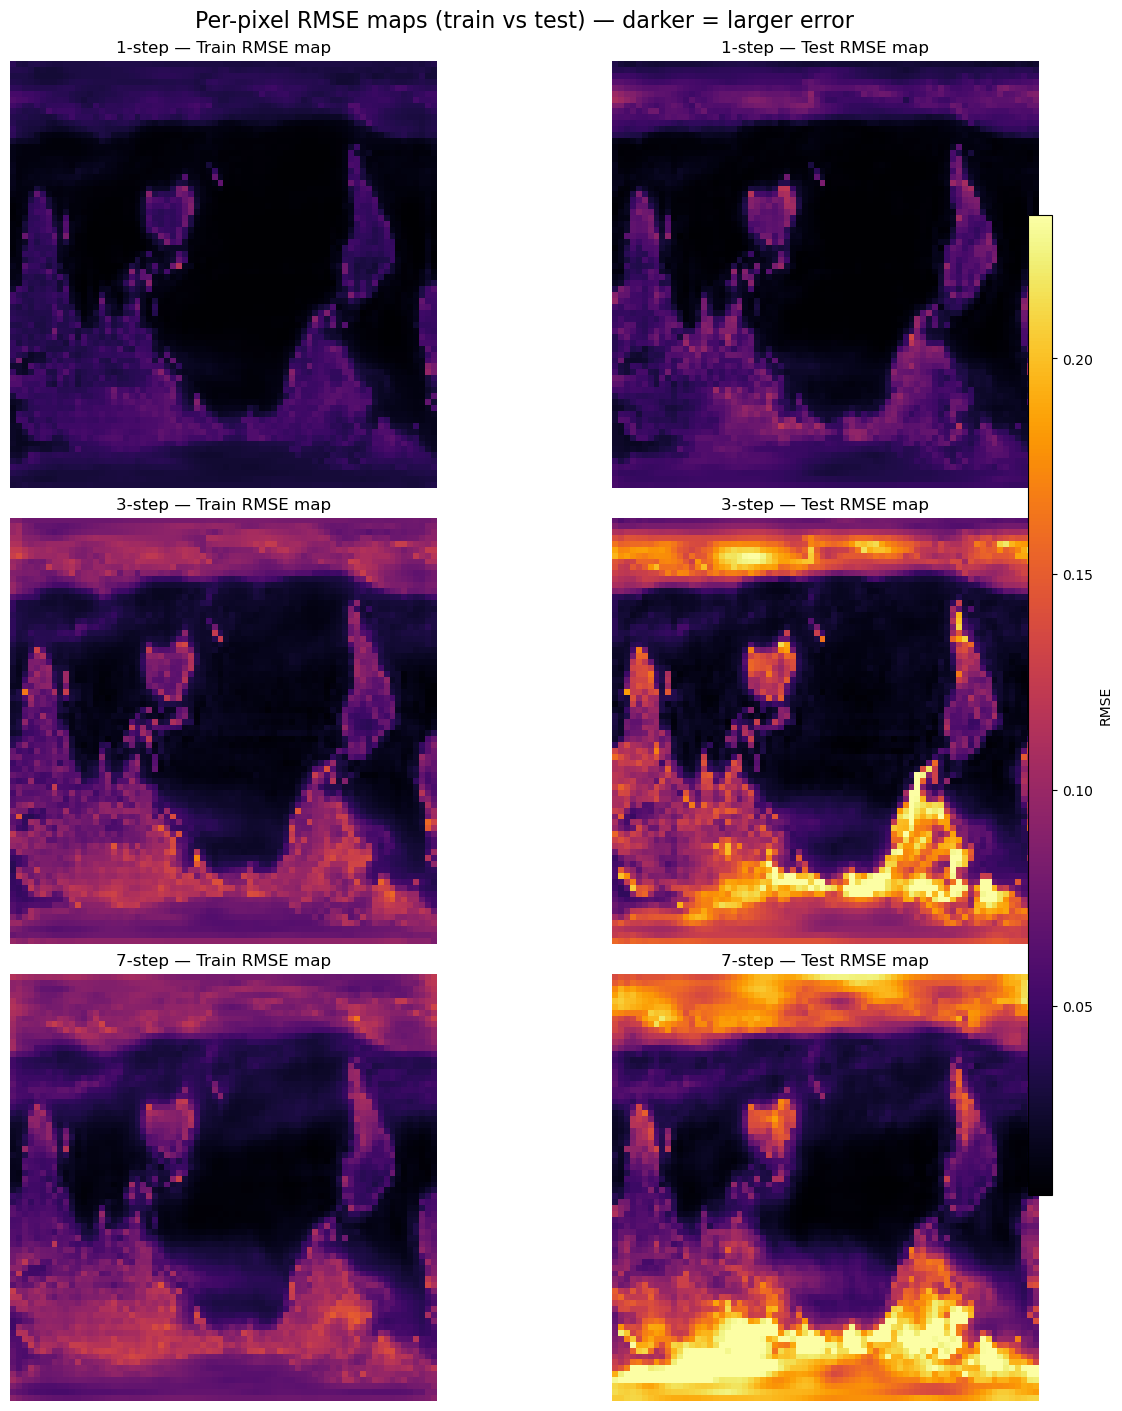

1-step mean RMSE - train: 0.0273, test: 0.0342
3-step mean RMSE - train: 0.0568, test: 0.0789
7-step mean RMSE - train: 0.0594, test: 0.0957


In [10]:
# Compute and plot per-pixel RMSE maps (train and test) for each model
# This creates 3×2 plots: rows = models (1-,3-,7-step), cols = [train, test]

def compute_rmse_map(model, dataloader, device):
    """Return per-pixel RMSE map (H, W) computed across all samples in dataloader."""
    model.eval()
    sum_sq = None
    count = 0
    with torch.no_grad():
        for data, target in dataloader:
            # data/target: (batch, 1, H, W)
            data = data.to(device)
            target = target.to(device)
            out = model(data)
            err = (out - target) ** 2  # squared error per pixel
            err_np = err.cpu().numpy()  # shape (batch, 1, H, W)
            if sum_sq is None:
                sum_sq = np.sum(err_np, axis=0)  # shape (1, H, W)
            else:
                sum_sq += np.sum(err_np, axis=0)
            count += err_np.shape[0]

    if count == 0:
        raise ValueError('Dataloader is empty; cannot compute RMSE map')

    mse_map = sum_sq / count  # shape (1, H, W)
    rmse_map = np.sqrt(mse_map)[0]  # drop channel -> (H, W)
    return rmse_map

# Compute maps for each model / dataset
maps = []  # [(model_name, train_map, test_map)]
models_info = [
    ('1-step', model_1, train_dataloader_1, test_dataloader_1),
    ('3-step', model_3, train_dataloader_3, test_dataloader_3),
    ('7-step', model_7, train_dataloader_7, test_dataloader_7),
]

for name, model, train_loader, test_loader in models_info:
    print(f'Computing RMSE maps for {name} model...')
    train_map = compute_rmse_map(model, train_loader, device)
    test_map = compute_rmse_map(model, test_loader, device)
    maps.append((name, train_map, test_map))

# Determine common color scale for comparability
all_vals = np.concatenate([m[1].ravel() for m in maps] + [m[2].ravel() for m in maps])
vmax = np.percentile(all_vals, 99)  # robust max (99th percentile)
vmin = np.percentile(all_vals, 1)

# Plot 3x2 grid
fig, axes = plt.subplots(3, 2, figsize=(12, 14), constrained_layout=True)
for i, (name, train_map, test_map) in enumerate(maps):
    im0 = axes[i,0].imshow(train_map, cmap='inferno', vmin=vmin, vmax=vmax)
    axes[i,0].set_title(f'{name} — Train RMSE map')
    axes[i,0].axis('off')

    im1 = axes[i,1].imshow(test_map, cmap='inferno', vmin=vmin, vmax=vmax)
    axes[i,1].set_title(f'{name} — Test RMSE map')
    axes[i,1].axis('off')

# Add a single colorbar on the right
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(im1, cax=cbar_ax, label='RMSE')

plt.suptitle('Per-pixel RMSE maps (train vs test) — darker = larger error', fontsize=16)
plt.show()

# Print mean RMSE per model/dataset for convenience
for name, train_map, test_map in maps:
    print(f"{name} mean RMSE - train: {train_map.mean():.4f}, test: {test_map.mean():.4f}")
